# **🚗 Traffic Accident Prediction Model**

# Objective:

Build a machine learning model to predict `Accident_Report` with the highest possible accuracy using the traffic accident dataset. The pipeline includes preprocessing (normalization, encoding, feature engineering), model selection, hyperparameter tuning, and evaluation, tailored to maximize accuracy.


### **📥 Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from category_encoders import TargetEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')




# **📊 Load and Inspect the Dataset**

In [2]:
# Load the dataset
df = pd.read_csv(r'D:\Desktop\DS\ds\1-cleaning\cleaned_traffic_data.csv')  # Replace with your actual file path
print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nMissing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset Shape: 5000 rows × 16 columns

Missing Values:
Series([], dtype: int64)


# **🧹 Preprocessing Pipeline**

In [3]:
# Apply advanced preprocessing with normalization, target encoding, power transformation, and new feature engineering.

# %%
# Define features and target
from sklearn.preprocessing import PowerTransformer


X = df.drop('Accident_Report', axis=1)
y = df['Accident_Report'].astype(int)

# Split numerical, categorical, and datetime columns
numeric_cols = ['Traffic_Speed_kmh', 'Vehicle_Count', 'Road_Occupancy_%', 'Sentiment_Score',
                'Ride_Sharing_Demand', 'Parking_Availability', 'Emission_Levels_g_km', 
                'Energy_Consumption_L_h']
categorical_cols = ['Traffic_Light_State', 'Weather_Condition', 'Traffic_Condition']
datetime_cols = ['Timestamp']

# Feature engineering
X['Timestamp'] = pd.to_datetime(X['Timestamp'], errors='coerce')
X['Hour'] = X['Timestamp'].dt.hour
X['DayOfWeek'] = X['Timestamp'].dt.dayofweek
X['IsWeekend'] = X['DayOfWeek'].isin([5, 6]).astype(int)
X['Month'] = X['Timestamp'].dt.month
X['IsRushHour'] = X['Hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
numeric_cols += ['Hour', 'DayOfWeek', 'IsWeekend', 'Month', 'IsRushHour']

# Interaction terms
X['Speed_Occupancy_Interaction'] = X['Traffic_Speed_kmh'] * X['Road_Occupancy_%']
numeric_cols.append('Speed_Occupancy_Interaction')

# Temporary target encoding for interaction term
temp_encoder = TargetEncoder(smoothing=10)
X['Weather_Condition_Encoded'] = temp_encoder.fit_transform(X['Weather_Condition'], y)
X['Vehicle_Weather_Interaction'] = X['Vehicle_Count'] * X['Weather_Condition_Encoded']
numeric_cols.append('Vehicle_Weather_Interaction')

# Handle skewness with PowerTransformer
skewed_cols = ['Emission_Levels_g_km', 'Energy_Consumption_L_h', 'Vehicle_Count', 'Ride_Sharing_Demand']
pt = PowerTransformer(method='yeo-johnson')
X[skewed_cols] = pt.fit_transform(X[skewed_cols])

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())  # Normalization
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(smoothing=10))  # Advanced target encoding
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X, y)

# Reconstruct preprocessed DataFrame
all_columns = numeric_cols + categorical_cols
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_columns)

#  **⚖️ Handle Class Imbalance with SMOTE**

In [4]:
# Check class distribution
print("\nClass Distribution Before SMOTE:")
print(y.value_counts(normalize=True))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Class Distribution Before SMOTE:
Accident_Report
0    0.904
1    0.096
Name: proportion, dtype: float64

Class Distribution After SMOTE:
Accident_Report
0    0.5
1    0.5
Name: proportion, dtype: float64


  File "c:\Users\YB Store\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# **🤖 Model Selection and Ensemble**

In [5]:
# Define individual models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
svm = SVC(random_state=42, probability=True)

# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('svm', svm)
    ],
    voting='soft'  # Soft voting for probability-based ensemble
)

# Evaluate models
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'SVM': svm,
    'Voting Classifier': voting_clf
}

print("\nCross-Validated Accuracy Scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")


Cross-Validated Accuracy Scores:
Random Forest: Mean Accuracy = 0.9663 ± 0.0022
XGBoost: Mean Accuracy = 0.9664 ± 0.0042
SVM: Mean Accuracy = 0.8536 ± 0.0043
Voting Classifier: Mean Accuracy = 0.9645 ± 0.0017


# **🔧 Hyperparameter Tuning for XGBoost**

In [6]:
# 🔧 Hyperparameter Tuning for XGBoost

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best XGBoost model
best_xgb = grid_search.best_estimator_

# Rebuild the voting classifier with the tuned XGBoost
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', best_xgb),
        ('svm', svm)
    ],
    voting='soft'  # استخدمي 'soft' لو بتفضلي الاحتمالات
)

# Train the new ensemble
voting_clf.fit(X_train, y_train)

# Print best parameters and accuracy from grid search
print("\nBest XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy (CV):", grid_search.best_score_)

# Evaluate voting classifier on test data
y_pred = voting_clf.predict(X_test)
print("\nVoting Classifier Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Accuracy (CV): 0.9681966122496968

Voting Classifier Test Accuracy: 0.9651548672566371
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       915
           1       0.98      0.95      0.96       893

    accuracy                           0.97      1808
   macro avg       0.97      0.96      0.97      1808
weighted avg       0.97      0.97      0.97      1808



# **📈 Train and Evaluate Final Model**


Test Set Performance (Voting Classifier):
Accuracy: 0.9652
F1-Score: 0.9642

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       915
           1       0.98      0.95      0.96       893

    accuracy                           0.97      1808
   macro avg       0.97      0.96      0.97      1808
weighted avg       0.97      0.97      0.97      1808



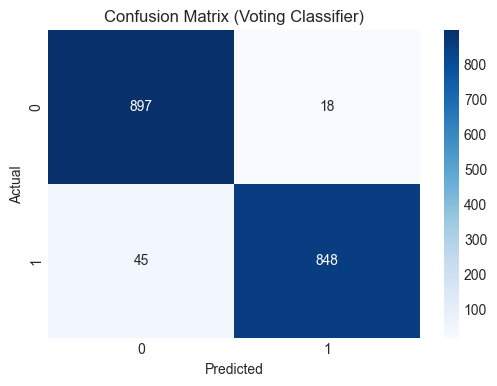

In [7]:
# Train voting classifier
voting_clf.fit(X_train, y_train)

# Predict on test set
y_pred = voting_clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print results
print("\nTest Set Performance (Voting Classifier):")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Voting Classifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **💡 Feature Importance**

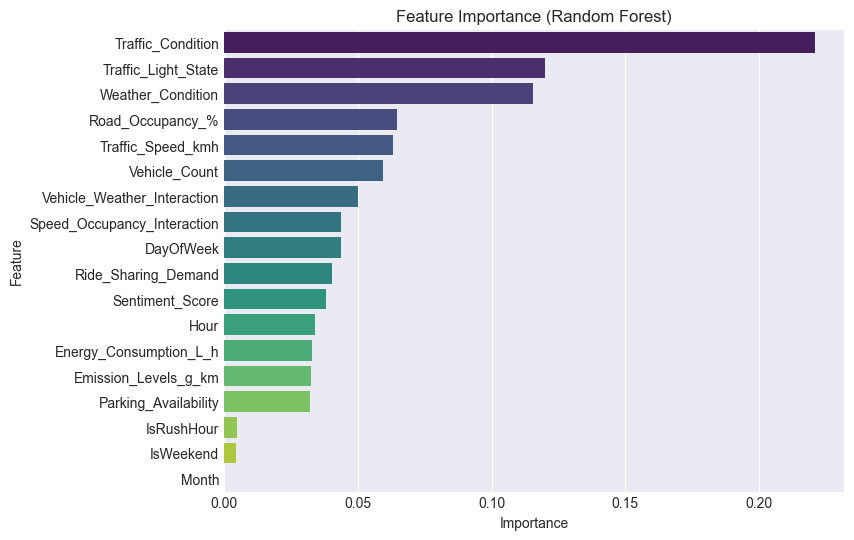

In [8]:
# Analyze feature importance for interpretability (using Random Forest as a proxy).

# %%
rf.fit(X_train, y_train)
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [10]:
import joblib

# حفظ الموديل والمعالجات (الصحيح)
joblib.dump(voting_clf, "model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")

print("✔️ تم حفظ الموديل والمعالجات بنجاح.")



✔️ تم حفظ الموديل والمعالجات بنجاح.
